In [36]:
import pandas as pd 
import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from IPython.display import display
from sklearn.metrics import classification_report,roc_auc_score
from utils import Preprocess
import cv2 
import joblib
plt.style.use('seaborn')

In [37]:
FILEPATH = 'labeled_data.csv'
MAPPINGS = {
    0: 'Hate Speech',
    1: 'Hate Speech',
    2: 'Neither'
}

In [38]:
df = pd.read_csv(FILEPATH)

In [39]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [40]:
df = df.iloc[:,-2:]
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [41]:
df['class'] = df['class'].map(MAPPINGS)

In [42]:
hate_df = df[df['class'] == 'Hate Speech']
hate_df.shape

(20620, 2)

In [43]:
normal_df = df[df['class'] == 'Neither']
normal_df.shape

(4163, 2)

In [44]:
hate_sample = hate_df.sample(len(normal_df))
assert hate_sample.shape == normal_df.shape

In [45]:
dataset = pd.concat([hate_sample, normal_df], axis=0)

In [46]:
dataset.head()

,class,tweet
23523,Hate Speech,Zelda bitches lol @joeylattime https://t.co/Cp...
1914,Hate Speech,&#8220;@swaqmagician: @100046729 wtf bitch!&#8...
11507,Hate Speech,If I was a guy I'd definitely dress up as the ...
15388,Hate Speech,RT @GuiltyZoE: &#128514;benzino bitch wasn't r...
14455,Hate Speech,RT @Br33zyF: Jackie a Old bamma ass bitch


In [47]:
dataset.reset_index(drop=True,inplace=True)

In [48]:
dataset.head()

,class,tweet
0,Hate Speech,Zelda bitches lol @joeylattime https://t.co/Cp...
1,Hate Speech,&#8220;@swaqmagician: @100046729 wtf bitch!&#8...
2,Hate Speech,If I was a guy I'd definitely dress up as the ...
3,Hate Speech,RT @GuiltyZoE: &#128514;benzino bitch wasn't r...
4,Hate Speech,RT @Br33zyF: Jackie a Old bamma ass bitch


In [49]:
dataset = dataset.sample(frac=1)
dataset.head()

,class,tweet
8137,Neither,and another one &#8220;@07Cannon: Two hoes? RT...
2968,Hate Speech,@TheRealCortlan All the thirsty hoes. Lol
6726,Neither,RT @FoodPornsx: Ultimate Chocolate Chip Cookie...
6818,Neither,RT @Jakelewis44_: We don't luv deez hoes&#1285...
5851,Neither,Have they seen Planet of the Apes &#8220;@What...


# Exploratory Data Analysis

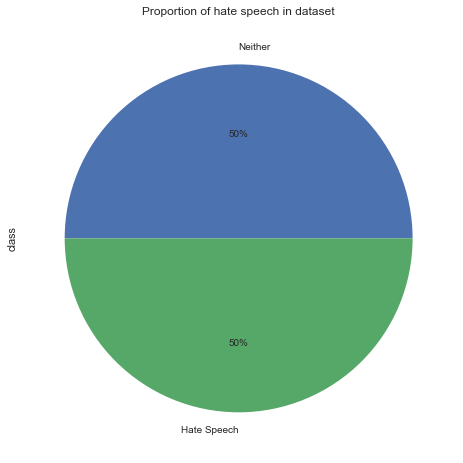

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
dataset['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax,title='Proportion of hate speech in dataset')
plt.show()

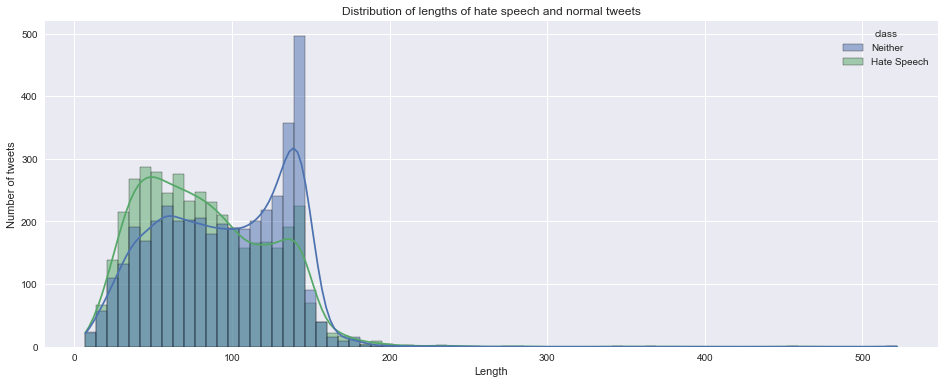

In [51]:
length = dataset['tweet'].apply(len)
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(x=length, hue=dataset['class'], kde=True, ax=ax)
ax.set_title('Distribution of lengths of hate speech and normal tweets')
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Length')
plt.show()

In [52]:
dataset['length'] = length
display(dataset.groupby(by='class')['length'].describe().transpose())

class,Hate Speech,Neither
count,4163.000000,4163.000000
mean,82.955801,94.850108
std,40.888657,41.054325
min,8.000000,7.000000
25%,49.500000,60.000000
50%,78.000000,97.000000
75%,114.000000,132.000000
max,455.000000,522.000000


In [53]:
hate_corpus = ' '.join([row['tweet'] for _,row in hate_sample.iterrows()])
normal_corpus = ' '.join([row['tweet'] for _,row in normal_df.iterrows()])

In [54]:
hate_cloud = WordCloud().generate(hate_corpus)
normal_cloud = WordCloud().generate(normal_corpus)

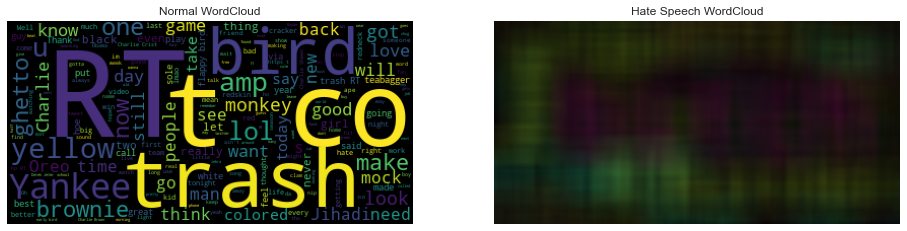

In [55]:
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].axis('off')
ax[0].set_title('Normal WordCloud')
ax[0].imshow(normal_cloud)
ax[1].axis('off')
ax[1].set_title('Hate Speech WordCloud')
hate_img = np.array(hate_cloud)
hate_img = cv2.cvtColor(hate_img, cv2.COLOR_BGR2RGB)
hate_img = cv2.blur(hate_img, (40,40))
ax[1].imshow(hate_img)
plt.show()

In [56]:
absurd_df = dataset[dataset['length']>=250]
absurd_df.index

Int64Index([218, 867, 6954, 6785, 66, 22, 3623], dtype='int64')

In [57]:
print(absurd_df.loc[6785]['tweet'])

RT @Iaughatmypain: My anaconda don't &#128581;
My anaconda don't &#9995;
My anaconda don't &#128683;

&#128079; Want 
&#128079; None 
&#128079; Unless 
&#128079; You 
&#128079; Got 

&#127838;&#127838;&#127838; Bunz &#127838;&#127838;&#127838;

&#128129;Hun


In [58]:
# Since we see that these tweets are absurd, we can safely remove them from our dataset
dataset = dataset[dataset['length']<250]

In [59]:
X = dataset['tweet']
y = dataset['class']

In [60]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [61]:
preprocessor = Preprocess(method='WordNetLemmatizer')
X_train,y_train = preprocessor.fit_transform(X_train,y_train)
X_val,y_val = preprocessor.transform(X_val, y_val)
X_test, y_test = preprocessor.transform(X_test,y_test)

In [62]:
models = {
    'Logistic':LogisticRegression(class_weight='balanced'),
    'DecisionTree':DecisionTreeClassifier(class_weight='balanced'),
    'RandomForest':RandomForestClassifier(class_weight='balanced',n_jobs=-1),
    'XGBoost':XGBClassifier(objective='binary:logistic',eval_metric='logloss',use_label_encoder=False, n_jobs=-1)
}
fitted_models = {}

In [63]:
def evaluate(model):
    model.fit(X_train,y_train)
    trainPreds = model.predict(X_train)
    valPreds = model.predict(X_val)

    header = '='*50 + f'Evaluating {model.__class__.__name__}' + '='*50
    print(header)
    print('Classification report for train set')
    print(classification_report(y_true=y_train, y_pred=trainPreds))
    print('Classification report on validation set')
    print(classification_report(y_true=y_val, y_pred=valPreds))
    return model

In [64]:
for name, model in models.items():
    fitted_models[name] = evaluate(model)

==================================================Evaluating LogisticRegression==================================================
Classification report for train set
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2993
           1       0.94      0.99      0.96      2996

    accuracy                           0.96      5989
   macro avg       0.96      0.96      0.96      5989
weighted avg       0.96      0.96      0.96      5989

Classification report on validation set
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       333
           1       0.92      0.97      0.94       333

    accuracy                           0.94       666
   macro avg       0.94      0.94      0.94       666
weighted avg       0.94      0.94      0.94       666

==================================================Evaluating DecisionTreeClassifier==================================================
Classi

In [65]:
# Since XGBoost performs significantly well on both train and test sets, we will check the performance of xgboost on test set
best_model = fitted_models['XGBoost']
testPreds = best_model.predict(X_test)
print('Classification Report for test set')
print(classification_report(y_true=y_test, y_pred=testPreds))

Classification Report for test set
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       832
           1       0.93      0.98      0.95       832

    accuracy                           0.95      1664
   macro avg       0.95      0.95      0.95      1664
weighted avg       0.95      0.95      0.95      1664



In [66]:
train_proba = best_model.predict_proba(X_train)
val_proba = best_model.predict_proba(X_val)
test_proba = best_model.predict_proba(X_test)

In [67]:
train_roc = roc_auc_score(y_true=y_train, y_score=train_proba[:,1])
val_roc = roc_auc_score(y_true=y_val, y_score=val_proba[:,1])
test_roc = roc_auc_score(y_true=y_test, y_score=test_proba[:,1])
print(f'The roc auc score on train set is -> {train_roc}')
print(f'The roc auc score on val set is -> {val_roc}')
print(f'The roc auc score on test set is -> {test_roc}')

The roc auc score on train set is -> 0.9948065289859693
The roc auc score on val set is -> 0.9812695578461345
The roc auc score on test set is -> 0.9759774292714497


In [68]:
preprocessor.predictNew('We are giving our NLP presentation today',model=best_model)

'Neither'

In [69]:
with open('models/textModel.pkl', 'wb') as f:
    joblib.dump(best_model, f)

In [70]:
with open('preprocess/textPreprocess.pkl','wb') as f:
    joblib.dump(preprocessor, f)